In [2]:
!pip install islp


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\harri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
from combine import train, test, groupAll
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.decomposition import PCA
from ISLP import load_data, confusion_table
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#train and test sets
x_train = train.iloc[:, 2:-1]
encoder = OneHotEncoder(sparse_output=False)
arr = np.array(train["Food Group"].tolist()).reshape(-1,1)
y_train = encoder.fit_transform(arr)

x_test = test.iloc[:, 2:-1]
encoder = OneHotEncoder(sparse_output=False)
arr = np.array(test["Food Group"].tolist()).reshape(-1,1)
y_test = encoder.fit_transform(arr)

def maxInd(food):
    maxval = 0; maxind = 0
    for index, value in enumerate(food):
        if value > maxval:
            maxind = index; maxval = value
    if maxind == 0: return 'Fruit'
    if maxind == 1: return 'Grain'
    if maxind == 2: return 'Meat'
    if maxind == 3: return 'Veg'

feature_names = list(x_train.columns)

c:\Users\harri\Downloads\CSE2600\Project\CSE2600\normalization.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '355.0126568973216' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.iloc[index, 2:] *= factor


In [4]:
#creating random forest model

rf = RF(n_estimators=1000,
        max_depth=4,
        bootstrap=True,
        random_state=2)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=1000, random_state=2)

In [5]:
#checking model accuracy

y_hat = rf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_hat))

Accuracy: 0.8295964125560538


In [6]:
#TRAIN confusion matrix, MSE, misclassification rate

y_hat_rf = rf.predict(x_train)
mse_rf = np.mean((y_train - y_hat_rf)**2)
print('train mse: ', mse_rf)

predictions_train = list(); pred_y = list()
for i in range(0, len(x_train)):
    predictions_train.append(maxInd(y_hat_rf[i]))
    pred_y.append(maxInd(y_train[i])) 

cf = confusion_table(predictions_train, pred_y)
print("Misclassification Rate: ", 1-(cf["Fruit"]["Fruit"]+cf["Meat"]["Meat"]+cf["Veg"]["Veg"]+cf["Grain"]["Grain"])/len(pred_y))
cf

train mse:  0.04223356009070295
Misclassification Rate:  0.08730158730158732


Truth,Fruit,Grain,Meat,Veg
Predicted,,,,
Fruit,84,25,2,18
Grain,0,92,0,2
Meat,0,0,383,0
Veg,25,5,0,246


In [7]:
#TEST confusion matrix, MSE, misclassification rate

y_hat_rf = rf.predict(x_test)
mse_rf = np.mean((y_test - y_hat_rf)**2)
print('test mse: ', mse_rf)

    
predictions_test = list(); pred_y = list()
for i in range(0, len(x_test)):
    predictions_test.append(maxInd(y_hat_rf[i]))
    pred_y.append(maxInd(y_test[i])) 

cf = confusion_table(predictions_test, pred_y)
print("Misclassification Rate: ", 1-(cf["Fruit"]["Fruit"]+cf["Meat"]["Meat"]+cf["Veg"]["Veg"]+cf["Grain"]["Grain"])/len(pred_y))
cf

test mse:  0.05829596412556054
Misclassification Rate:  0.11659192825112108


Truth,Fruit,Grain,Meat,Veg
Predicted,,,,
Fruit,19,4,2,6
Grain,1,25,1,2
Meat,0,0,94,0
Veg,8,2,0,59


In [8]:
#testing for best max_depth hyperparameter

bestrate = 100
for sz in range(1, 15):
    rf2 = RF(max_depth=sz, random_state=2)
    rf2.fit(x_train, y_train)
    y_hat_rf = rf2.predict(x_test)

    predictions_test = list(); pred_y = list()
    for i in range(0, len(x_test)):
        predictions_test.append(maxInd(y_hat_rf[i]))
        pred_y.append(maxInd(y_test[i])) 

    cf = confusion_table(predictions_test, pred_y)
    rate = 1-((cf["Fruit"]["Fruit"]+cf["Meat"]["Meat"]+cf["Veg"]["Veg"]+cf["Grain"]["Grain"])/len(pred_y))
    if rate < bestrate:
        bestrate = rate
        besttree = rf2
        bestsz = sz

print("Best depth is of size:", bestsz, "with a misclassfication rate of: ", bestrate)
predictions_test = list(); pred_y = list()
y_hat_rf = besttree.predict(x_test)

for i in range(0, len(x_test)):
    predictions_test.append(maxInd(y_hat_rf[i]))
    pred_y.append(maxInd(y_test[i])) 

cf = confusion_table(predictions_test, pred_y)
print("Misclassification Rate: ", 1-(cf["Fruit"]["Fruit"]+cf["Meat"]["Meat"]+cf["Veg"]["Veg"]+cf["Grain"]["Grain"])/len(pred_y))
cf

Best depth is of size: 13 with a misclassfication rate of:  0.094170403587444
Misclassification Rate:  0.094170403587444


Truth,Fruit,Grain,Meat,Veg
Predicted,,,,
Fruit,21,3,2,6
Grain,1,27,0,1
Meat,0,0,94,0
Veg,6,1,1,60


In [9]:
#testing for best n_estimators hyperparameter

bestrate = 100
n_estimators = [1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 5000, 10000]
for n in n_estimators:
    rf3 = RF(n_estimators=n, random_state=2)
    rf3.fit(x_train, y_train)
    y_hat_rf = rf3.predict(x_test)

    predictions_test = []
    pred_y = []
    for i in range(len(x_test)):
        predictions_test.append(maxInd(y_hat_rf[i]))
        pred_y.append(maxInd(y_test[i])) 

    cf = confusion_table(predictions_test, pred_y)
    rate = 1 - ((cf["Fruit"]["Fruit"] + cf["Meat"]["Meat"] + cf["Veg"]["Veg"] + cf["Grain"]["Grain"]) / len(pred_y))
    
    if rate < bestrate:
        bestrate = rate
        besttree = rf3
        best_n = n

print("Best n_estimators (number of trees):", best_n, "with a misclassification rate of:", bestrate)
cf

Best n_estimators (number of trees): 100 with a misclassification rate of: 0.09865470852017932


Truth,Fruit,Grain,Meat,Veg
Predicted,,,,
Fruit,21,3,3,7
Grain,1,27,0,2
Meat,0,0,94,0
Veg,6,1,0,58


In [10]:
#model with best hyperparameters

rfbest = RF(max_depth=bestsz, n_estimators=best_n, random_state=2)
rfbest.fit(x_train, y_train)
y_hat_rf = rfbest.predict(x_test)

predictions_test = []
pred_y = []
for i in range(len(x_test)):
    predictions_test.append(maxInd(y_hat_rf[i]))
    pred_y.append(maxInd(y_test[i])) 

cf = confusion_table(predictions_test, pred_y)
rate = 1 - ((cf["Fruit"]["Fruit"] + cf["Meat"]["Meat"] + cf["Veg"]["Veg"] + cf["Grain"]["Grain"]) / len(pred_y))
print("Misclassification Rate:", rate)

y_hat_best = rfbest.predict(x_test)
print("Accuracy:", accuracy_score(predictions_test, pred_y))
cf

Misclassification Rate: 0.094170403587444
Accuracy: 0.905829596412556


Truth,Fruit,Grain,Meat,Veg
Predicted,,,,
Fruit,21,3,2,6
Grain,1,27,0,1
Meat,0,0,94,0
Veg,6,1,1,60


Truth      Fruit  Grain  Meat  Veg
Predicted                         
Fruit         21      3     2    6
Grain          1     27     0    1
Meat           0      0    94    0
Veg            6      1     1   60


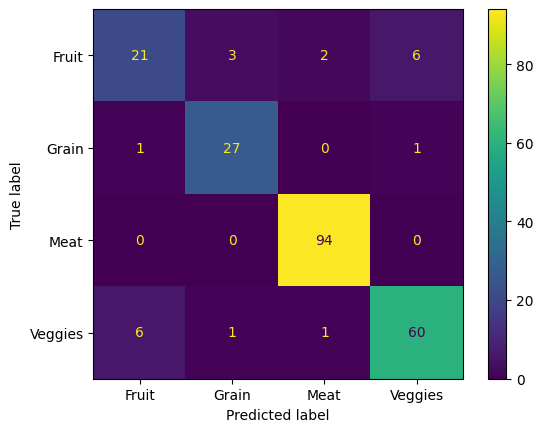

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(predictions_test, pred_y)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Fruit', "Grain", "Meat", "Veggies"])
print(cf)
cm_display.plot()
plt.show()

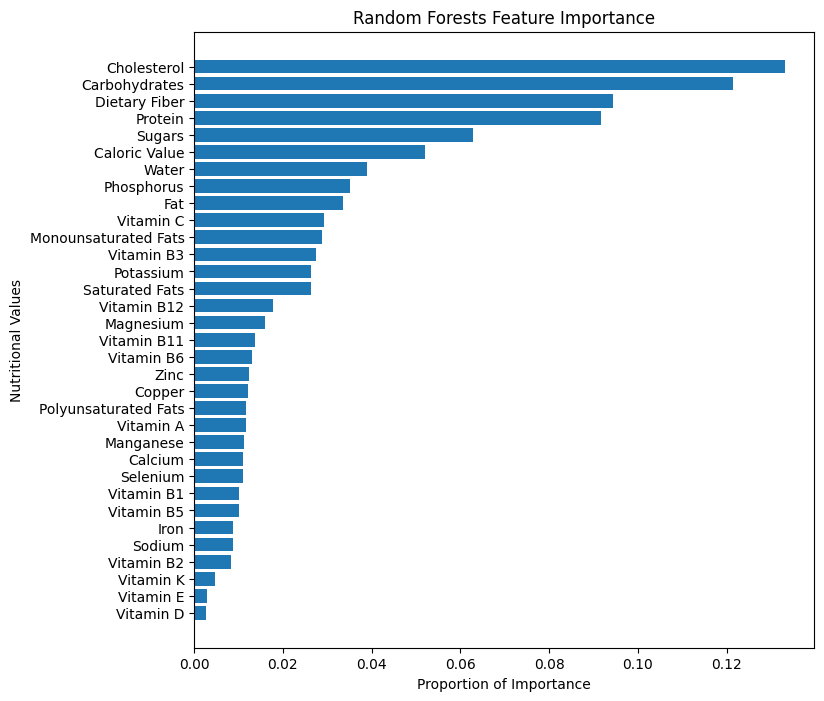

In [13]:
feature_imp = pd.DataFrame(
    {'importance':rfbest.feature_importances_},
    index=feature_names)
feature_imp = feature_imp.sort_values(by='importance', ascending=True)

fig, ax = plt.subplots(figsize =(8, 8))

plt.barh(range(len(feature_imp)), feature_imp['importance'])

plt.title("Random Forests Feature Importance")
plt.ylabel("Nutritional Values")
plt.xlabel("Proportion of Importance")

plt.yticks(range(len(feature_imp)), feature_imp.index.to_list())

plt.show()